In [1]:
import pandas as pd
import numpy as np
import pylab as plt
import scipy.optimize as op
from datetime import datetime

import os
from pandas.tseries.offsets import BDay

## a) Loading the return series

In [2]:
ret_file = os.path.join('MFE_DAM', 'Data', 'US.csv')
us_ret = pd.read_csv(ret_file, parse_dates=[0], index_col=[0], na_values=[0])
us_ret = us_ret.fillna(method='ffill')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026457BD0B00>,
      dtype=object)

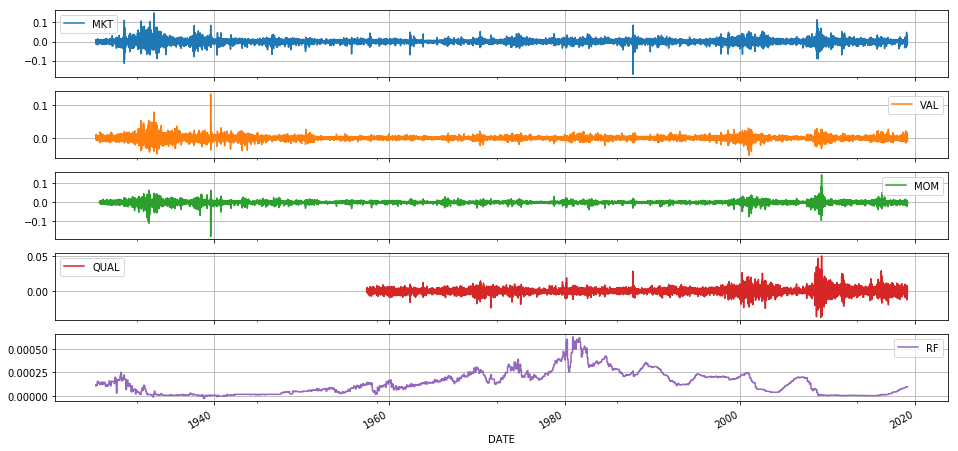

In [3]:
us_ret.plot(figsize=(16,8), grid=True, subplots=True)

In [4]:
us_Price = (us_ret+1).cumprod().shift(1)
for col in us_Price.columns:
    lastNanRow = max(np.where(us_Price[col].isnull())[0])
    us_Price.loc[us_Price.index[lastNanRow],col] = 1
us_Price

,MKT,VAL,MOM,QUAL,RF
DATE,,,,,
1926-07-31,1.000000,1.000000,NaN,NaN,1.000000
1926-08-02,1.004327,1.000119,NaN,NaN,1.000106
1926-08-03,1.012653,1.001592,NaN,NaN,1.000226
1926-08-04,1.017484,0.999310,NaN,NaN,1.000346
1926-08-05,1.013819,1.000493,NaN,NaN,1.000466
1926-08-06,1.012916,1.007472,NaN,NaN,1.000586
1926-08-07,1.019714,1.009039,NaN,NaN,1.000706
1926-08-09,1.024276,1.007618,NaN,NaN,1.000826
1926-08-10,1.026235,1.006002,NaN,NaN,1.000946


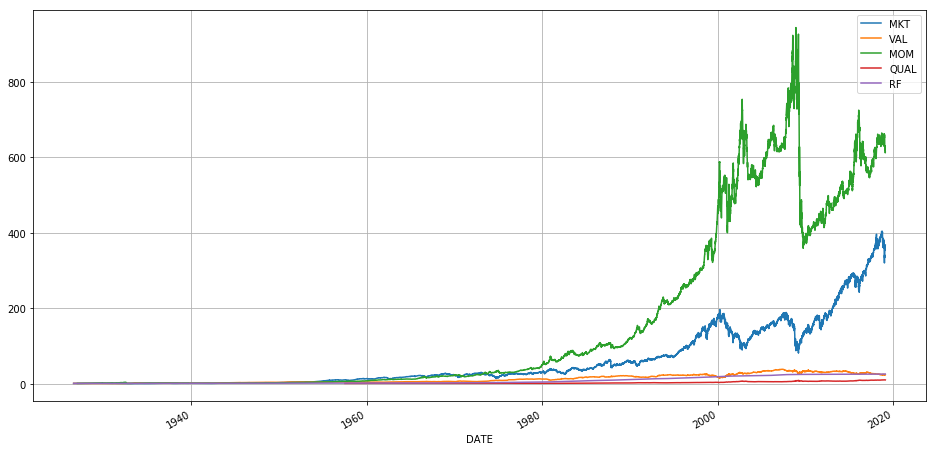

In [5]:
us_Price.plot(figsize=(16,8), grid=True, subplots=False)

## b) Functions definition

In [17]:
def adjustWeights(weights, df_Price):
    weights_adj = weights.copy()
    mask, _ = df_Price.align(weights_adj, join='right', axis=0)
    weights_adj[mask.isnull()] = 0
    weights_adj['RF'] = 1-weights_adj.sum(axis = 1, skipna = True)
    return weights_adj

In [6]:
def convertWeights2Shares(weights, df_Price, GMV, Tcost_vec):
    """
    Tcost considered
    """
    turnover = 0
    shares = pd.DataFrame(columns = weights.columns, index = weights.index)
    idx = weights.index
    asset_Price = df_Price.reindex(columns=weights.columns)

    shares.loc[idx[0],:] = GMV*weights.loc[idx[0],:]/asset_Price.loc[idx[0],:]
    for i in range(1,len(idx)):
        if abs(weights.loc[idx[i],:].sum()) < 1e-10:
            shares.loc[idx[i],:] = shares.loc[idx[i-1],:]
        else:
            val_wo_rebalance = shares.loc[idx[i-1],:]*asset_Price.loc[idx[i],:]
            GMV_wo_rebalance = val_wo_rebalance.sum()
            val_before_Tcost = GMV_wo_rebalance*weights.loc[idx[i],:]
            val_abs_diff = val_before_Tcost.subtract(val_wo_rebalance, fill_value=0).abs()
            cost = (val_abs_diff*Tcost_vec).sum()
            val_after_Tcost = (GMV_wo_rebalance-cost)*weights.loc[idx[i],:]
            shares.loc[idx[i],:] = val_after_Tcost/asset_Price.loc[idx[i],:]
            turnover += cost
    return (shares, turnover)

In [7]:
def df2Daily(df, idx):
    """
    Change the weights frequency into daily basis
    Forward fill the inbetween elements
    """
    df_daily = pd.DataFrame(index = idx)
    for col in df.columns:
        df_daily[col] = df[col]
    df_daily.fillna(method='ffill',inplace=True)
    return df_daily

In [8]:
def calcPnl(df_Price, shares_daily):
    price_reindexed = df_Price.reindex(columns=shares_daily.columns)
    pnl = shares_daily*price_reindexed.values
    nonNanRow = min(np.where((~pnl.isnull()).any(axis=1))[0])
    pnl = pnl.sum(axis=1)
    pnl.iloc[:nonNanRow] = np.nan
    pnl = pnl/pnl[nonNanRow]-1
    pnl.dropna(inplace=True)
    return (pnl, nonNanRow)

In [9]:
def cumul_perf(ret):
    """
    Function to calculate the cumulative excess return series
    """
    return ((1 + ret).cumprod(axis=0)) - 1

In [10]:
def SR(pnl):
    pnl_diff = pnl.diff()
    pnl_diff.dropna(inplace=True)
    rsl = np.sqrt(252)*pnl_diff.mean()/pnl_diff.std(ddof=0)
    return rsl

In [11]:
def maxDrawDown(pnl):
    T = pnl.iloc[0]
    Vmin = pnl.iloc[0]
    Tmax = max(0.,T)
    for i in range(1,len(pnl)):
        T = pnl.iloc[i]
        if T-Tmax < Vmin:
            Vmin = T-Tmax
        if T>Tmax:
            Tmax = T
    return Vmin

## c) Parameter Configuration

In [12]:
day_lag = 1
GMV = 1e6
Tcost_vec = np.array([50e-4,50e-4,50e-4,50e-4, 50e-4])

## d) Testing weights

In [13]:
testingFile = os.path.join('MFE_DAM', 'test_weights.csv')
weights = pd.read_csv(testingFile, parse_dates=[0], index_col=[0])
weights.index = weights.index + BDay(day_lag)
weights['RF'] = 0.

In [15]:
weights.drop(weights.loc[:'1926-7-31'].index, axis=0, inplace=True)

In [16]:
weights.loc[weights.isnull().any(axis=1)]

,MKT,VAL,MOM,QUAL,RF
Date,,,,,


In [23]:
weights = adjustWeights(weights, us_Price)
(shares, turnover) = convertWeights2Shares(weights, us_Price, GMV, Tcost_vec)
shares_daily = df2Daily(shares, us_Price.index)
shares

,MKT,VAL,MOM,QUAL,RF
Date,,,,,
1926-08-02,658592,112839,NaN,NaN,225682
1926-09-01,620683,121445,NaN,NaN,255183
1926-10-01,608875,125830,NaN,NaN,262614
1926-11-01,632581,117689,NaN,NaN,247466
1926-12-01,616973,122954,NaN,NaN,257556
1927-01-03,590464,130512,140141,NaN,137732
1927-02-01,587482,128371,141197,NaN,142046
1927-03-01,557722,135897,153467,NaN,152712
1927-04-01,543182,143593,153207,NaN,159660


In [24]:
turnover

26256885.164526545

In [27]:
perf, nonNanRow = calcPnl(us_Price, shares_daily)
perf_MKT = cumul_perf(us_ret.loc[us_ret.index[nonNanRow]:,'MKT'])

Text(0.5,1,'Pnl Comparison')

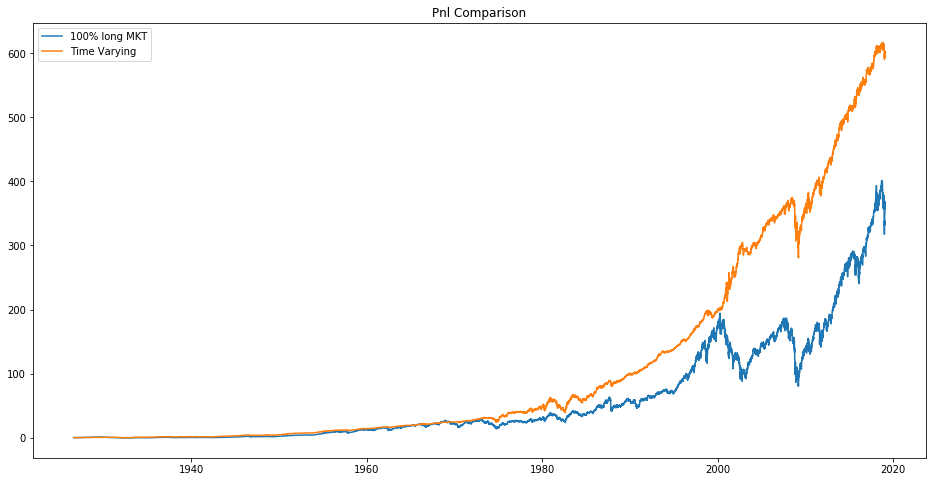

In [28]:
plt.figure('Pnl Comparison',figsize=(16,8))
plt.clf()
plt.plot(perf_MKT.index, perf_MKT.values, label='100% long MKT')
plt.plot(perf.index, perf.values, label='Time Varying')
plt.legend(loc = 'best')
plt.title('Pnl Comparison')

In [29]:
SR(perf)

0.5239572977324446

In [30]:
SR(perf_MKT)

0.24018991744633209

In [31]:
maxDrawDown(perf)

-94.07266755436916

In [32]:
maxDrawDown(perf_MKT)

-114.15000474181704

In [33]:
maxDrawDown(perf)/perf.iloc[-1]

-0.15627277620659183

In [34]:
maxDrawDown(perf_MKT)/perf_MKT.iloc[-1]

-0.3102061239314019